In [21]:
from enum import auto
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from xgboost import XGBRegressor


plt.style.use('seaborn-v0_8')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10
)


def score_dataset(X, y, model=XGBRegressor()):
  for colname in X.select_dtypes(['category', 'object']):
    X[colname], _ = X[colname].factorize()

  score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
  score = -1 * score.mean()
  score = np.sqrt(score)
  return score

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ames.csv")
df.head()



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Above_Average,Average,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,Typical,Typical,CBlock,Typical,Good,Gd,BLQ,2.0,Unf,0.0,441.0,1080.0,GasA,Fair,Y,SBrkr,1656.0,0.0,0.0,1656.0,1,0,1,0,3,1,Typical,7,Typ,2,Good,Attchd,Fin,2,528.0,Typical,Typical,Partial_Pavement,210.0,62.0,0.0,0.0,0.0,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,North_Ames,Feedr,Norm,OneFam,One_Story,Average,Above_Average,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Typical,Typical,CBlock,Typical,Typical,No,Rec,6.0,LwQ,144.0,270.0,882.0,GasA,Typical,Y,SBrkr,896.0,0.0,0.0,896.0,0,0,1,0,2,1,Typical,5,Typ,0,No_Fireplace,Attchd,Unf,1,730.0,Typical,Typical,Paved,140.0,0.0,0.0,0.0,120.0,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Above_Average,Above_Average,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,Typical,Typical,CBlock,Typical,Typical,No,ALQ,1.0,Unf,0.0,406.0,1329.0,GasA,Typical,Y,SBrkr,1329.0,0.0,0.0,1329.0,0,0,1,1,3,1,Good,6,Typ,0,No_Fireplace,Attchd,Unf,1,312.0,Typical,Typical,Paved,393.0,36.0,0.0,0.0,0.0,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Good,Average,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Good,Typical,CBlock,Typical,Typical,No,ALQ,1.0,Unf,0.0,1045.0,2110.0,GasA,Excellent,Y,SBrkr,2110.0,0.0,0.0,2110.0,1,0,2,1,3,1,Excellent,8,Typ,2,Typical,Attchd,Fin,2,522.0,Typical,Typical,Paved,0.0,0.0,0.0,0.0,0.0,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,OneFam,Two_Story,Average,Average,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Typical,Typical,PConc,Good,Typical,No,GLQ,3.0,Unf,0.0,137.0,928.0,GasA,Good,Y,SBrkr,928.0,701.0,0.0,1629.0,0,0,2,1,3,1,Typical,6,Typ,1,Typical,Attchd,Fin,2,482.0,Typical,Typical,Paved,212.0,34.0,0.0,0.0,0.0,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


K-means algoritaması ölçeğe duyarlıdır. Bu, seçimlerimize bağlı olarak çok farklı sonuçlar elde edebileceğimiz için, özelliklerimizi nasıl ve ne şekilde yeniden ölçeklendireceğimiz konusunda dikkatli olmamız gerektiği anlamına gelir. Genel bir kural olarak, özellikler zaten doğrudan karşılaştırılabilir durumdaysa (Farklı zamanlarda yapılan test sonuçları gibi), yeniden ölçeklendirme yapmak istemezsiniz. Öte yandan, karşılaştırılabilir ölçeklerde olmayan özellikler(boy ve kilo gibi) genellikle yeniden ölçekledirmeden fayda sağlar. Bazen seçim net olmayabilir. Bu durumda, daha büyük değerlere sahip özelliklerin daha fazla ağırlıklandırılacağını unutöadam sağduyunuzu kullanmaya çalışmalısınız.

# 1) Ölçeklendirme Özelllikleri

Aşağıdaki özellik kümelerini ele alın. Her biri için şunu belirleyin:

* Kesinlikle yeniden ölçeklendirilmelidir,
* Kesinlikle yeniden ölçeklendirilmemelidirler, veya
* Her ikisi de makul olabilir

Özellikler:

1. Kaliforniya'daki şehirlerin `Latitude(enlem)` ve `Longitude(boylamları)`
2. Ames, Iowa'daki evlerin `Lot Area(Arsa Alanı)` ve `Living Area(Yaşam Alanı)`
3. 1989 model bir otomobilin `Number of Doors(Kapı Sayısı)` and `Horsepower(Beygir Gücü)`

Cevaplarınızı düşündükten sonra, tartışma için aşağıdaki hücreyi çalıştırın.

# 2) Küme Etiketlerinin Özelliğini Oluşturun

Aşağıdaki parametrelerle k-means kümeleme oluşturma:

- Özellikler: `LotArea`, `TotalBsmtSF`, `FirstFlrSF`, `SecondFlrSF`,`GrLivArea`
- küme sayısı: 10
- iterasyonlar: 10

In [22]:
X = df.copy()
y = X.pop('SalePrice')

features =  ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea']

X_scaled = X.loc[:,features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)
X["Cluster"]

,Cluster
0,8
1,2
2,1
3,9
4,7
...,...
2925,1
2926,2
2927,2
2928,6


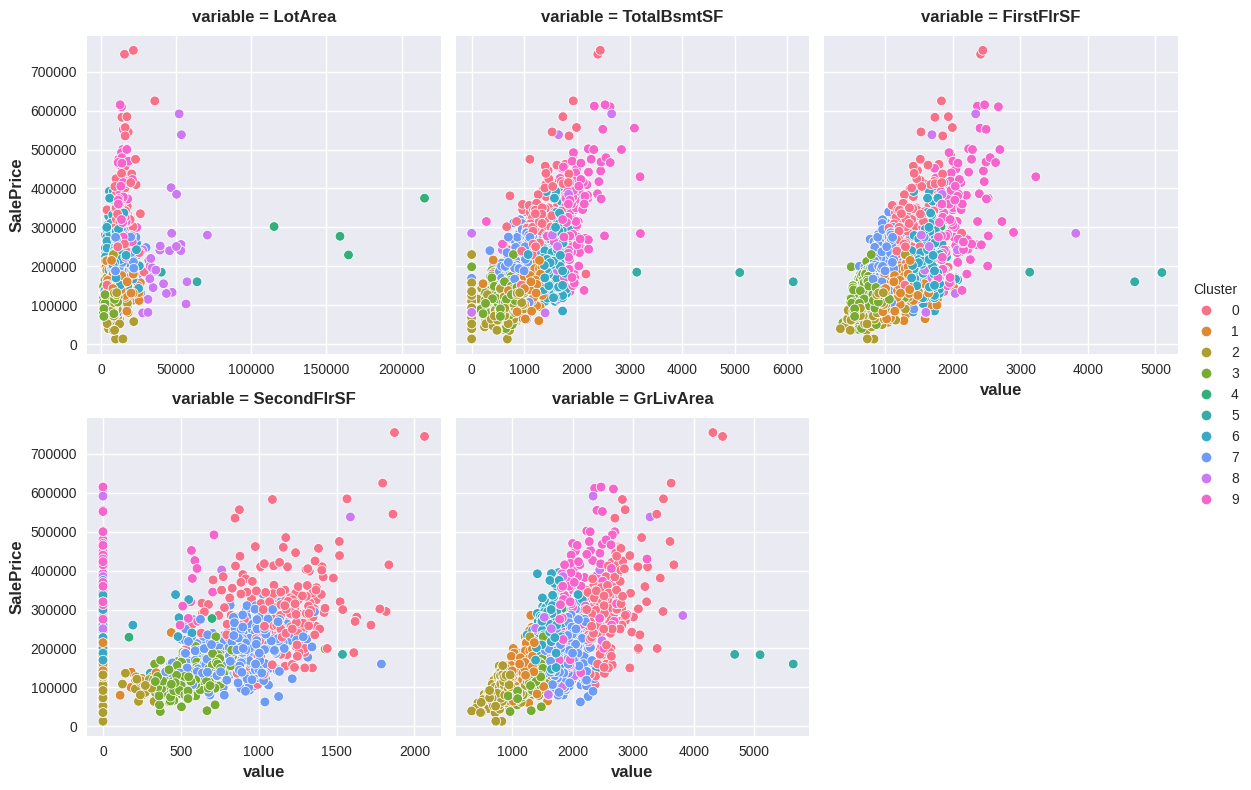

In [23]:
Xy = X.copy()
Xy["Cluster"] = Xy["Cluster"].astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable", height=4, aspect=1, facet_kws={'sharex':False}, col_wrap=3,
    data=Xy.melt(
        id_vars=["Cluster", "SalePrice"],
        value_vars=features))

Ve daha önce olduğu gibi, score_dataset, eğitim verilerine eklenen bu yeni özellik ile XGBoost modelinizi puanlayacaktır.

In [24]:
score_dataset(X, y)

np.float64(127.96504420763704)

k-means algoritması, özellikler oluşturmanın alternatif bir yolunu sunar. Her özelliği en yakın küme merkezine göre etiketlemek yerine, bir noktadan tüm merkezlere olan mesafeyi ölçebilir ve bu mesafeleri özellikler olarak döndürebilir.

# 3) Küme-Mesafe Özellikleri

Şimdi veri kümenize küme mesafesi özelliklerini ekleyin. Bu mesafe özelliklerini fit_predict yerine kmeans'in fit_transform yöntemini kullanarak elde edebilirsiniz.

In [25]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)


X_cd = kmeans.fit_transform(X_scaled)

X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,Cluster,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,Centroid_9
0,0,0,141.0,31770.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1960,1960,0,0,0,0,0,112.0,0,0,0,0,0,0,0,2.0,0,0.0,441.0,1080.0,0,0,...,0,3,1,0,7,0,2,0,0,0,2,528.0,0,0,0,210.0,62.0,0.0,0.0,0.0,0.0,0,0,-1,0.0,5,2010,0,0,8,4.134181,3.236678,3.977023,4.316398,16.792665,13.097627,2.870851,3.789935,1.604330,3.315926
1,0,1,80.0,11622.0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1961,1961,1,0,1,1,-1,0.0,0,0,0,0,1,1,1,6.0,1,144.0,270.0,882.0,0,1,...,0,2,1,0,5,0,0,1,0,1,1,730.0,0,0,1,140.0,0.0,0.0,0.0,120.0,0.0,0,1,-1,0.0,6,2010,0,0,2,4.615628,1.075352,0.621685,1.885029,19.594509,15.785445,2.575580,2.745164,4.932333,4.508933
2,0,0,81.0,14267.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1958,1958,0,0,2,2,1,108.0,0,0,0,0,1,1,2,1.0,0,0.0,406.0,1329.0,0,1,...,1,3,1,1,6,0,0,1,0,1,1,312.0,0,0,1,393.0,36.0,0.0,0.0,0.0,0.0,0,0,0,12500.0,6,2010,0,0,1,3.707220,0.953832,2.157567,2.713650,19.030448,14.058973,0.975653,2.618381,3.927018,2.780135
3,0,0,93.0,11160.0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,1968,1968,0,0,0,3,-1,0.0,1,0,0,0,1,1,2,1.0,0,0.0,1045.0,2110.0,0,2,...,1,3,1,2,8,0,2,2,0,0,2,522.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-1,0.0,4,2010,0,0,9,3.874506,3.792481,5.085077,5.236814,19.392116,11.373003,2.243512,4.444882,4.673607,0.508460
4,1,0,74.0,13830.0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1997,1998,1,0,1,1,-1,0.0,0,0,1,1,1,1,3,3.0,0,0.0,137.0,928.0,0,3,...,1,3,1,0,6,0,1,2,0,0,2,482.0,0,0,1,212.0,34.0,0.0,0.0,0.0,0.0,0,1,-1,0.0,3,2010,0,0,7,2.651716,2.070336,2.337714,1.306043,19.225117,14.749591,2.660527,0.733775,4.390193,4.103626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,0,37.0,7937.0,0,0,0,0,0,2,0,22,0,0,0,4,0,1,1984,1984,1,0,4,5,-1,0.0,0,0,0,0,1,3,3,3.0,0,0.0,184.0,1003.0,0,1,...,0,3,1,0,6,0,0,1,3,1,2,588.0,0,0,1,120.0,0.0,0.0,0.0,0.0,0.0,0,2,-1,0.0,3,2006,0,0,1,4.385914,0.632596,0.786743,1.872145,19.983709,15.515254,2.158623,2.615104,5.110022,4.128159
2926,0,0,0.0,8885.0,0,0,0,3,0,1,1,22,0,0,0,0,1,0,1983,1983,1,0,4,5,-1,0.0,0,0,0,1,1,3,0,2.0,6,324.0,239.0,864.0,0,1,...,0,2,1,0,5,0,0,1,0,1,2,484.0,0,0,1,164.0,0.0,0.0,0.0,0.0,0.0,0,1,-1,0.0,6,2006,0,0,2,4.637266,1.039369,0.404809,1.791325,19.937172,15.897940,2.586619,2.737873,5.212695,4.548788
2927,4,0,62.0,10441.0,0,0,1,0,0,1,0,22,0,0,0,3,1,0,1992,1992,1,0,4,6,-1,0.0,0,0,1,1,1,3,3,3.0,0,0.0,575.0,912.0,0,1,...,0,3,1,0,6,0,0,1,4,3,0,0.0,1,1,1,80.0,32.0,0.0,0.0,0.0,0.0,0,1,1,700.0,7,2006,0,0,2,4.453410,0.806070,0.628910,1.845923,19.701445,15.610602,2.335405,2.629335,4.917455,4.284502
2928,0,0,77.0,10010.0,0,0,1,0,0,1,1,22,0,0,0,0,1,0,1974,1975,1,0,4,5,-1,0.0,0,0,0,1,1,3,2,1.0,1,123.0,195.0,1389.0,0,3,...,0,2,1,0,6,0,1,2,0,2,2,418.0,0,0,1,240.0,38.0,0.0,0.0,0.0,0.0,0,0,-1,0.0,4,2006,0,0,6,3.645022,0.954872,2.256738,2.748809,19.548612,14.012415,0.623647,2.635832,4.385419,2.586722


In [26]:
score_dataset(X, y)

np.float64(125.41572431816515)